In [1]:
#run below code twice
from line_profiler import LineProfiler

import numpy as np
import pandas as pd
import plotnine as gg
import torch
# from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax

import warnings
warnings.filterwarnings('ignore')

import pipeline


training data count (251, 2)


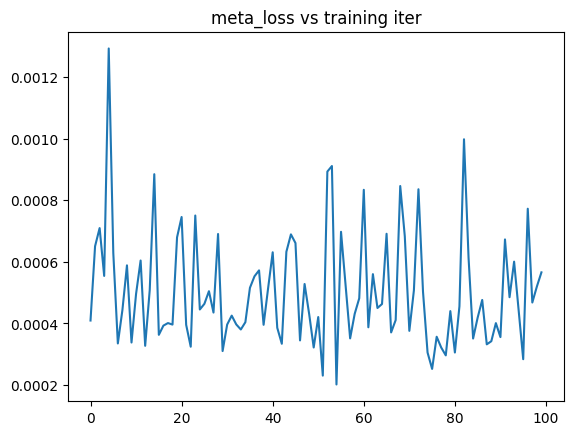

training epoch ends in  2.61 minutes.


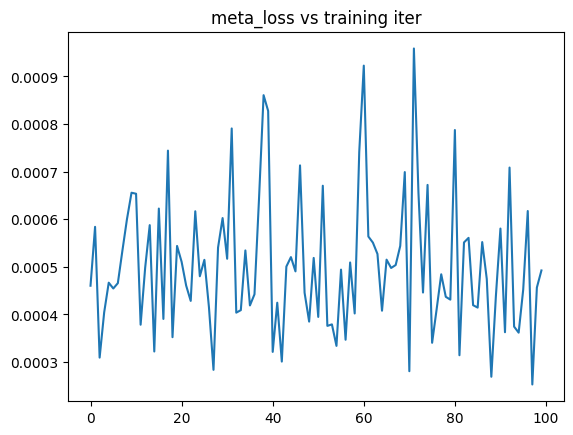

training epoch ends in  3.22 minutes.


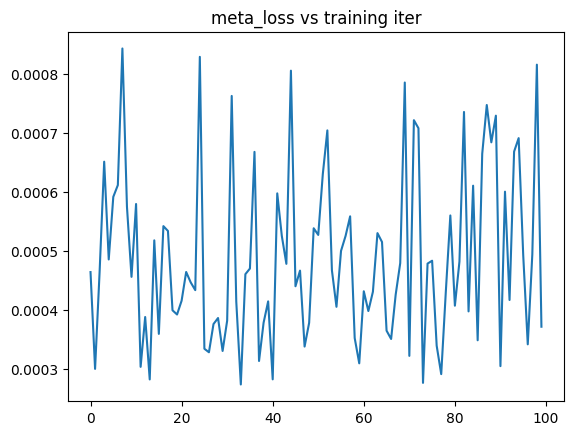

training epoch ends in  2.6 minutes.


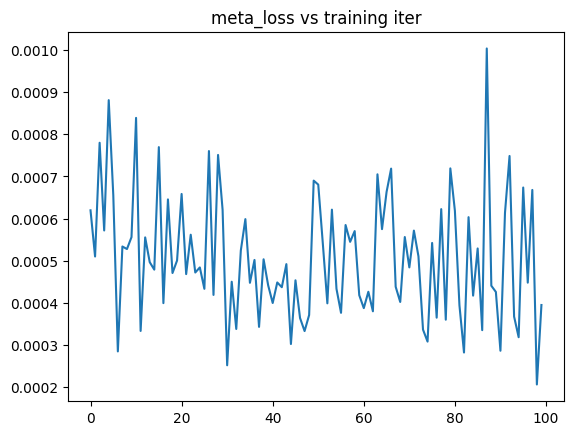

training epoch ends in  2.6 minutes.


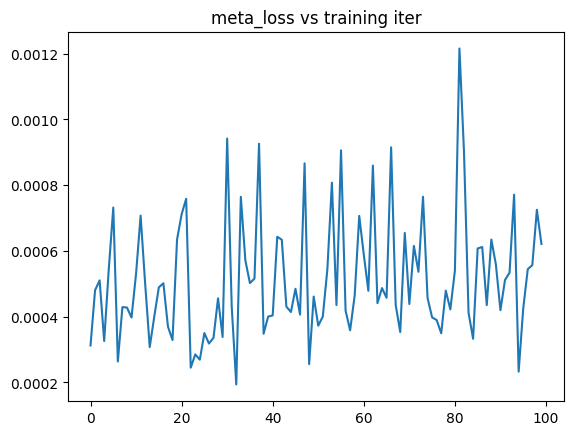

training epoch ends in  2.6 minutes.
test starts


In [2]:
#data generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Dataset_generator.ipynb
#predictor (a logistic regression) generated from https://github.com/dakshmittal30/Adaptive_sampling/blob/49060b32a7c95ab5f8057ff593629d64ea411c14/src/notebooks/Predictor.ipynb 
#biased data from https://github.com/dakshmittal30/Adaptive_sampling/blob/7cf3996c786ce33db90fcb7aef8584054169557c/src/notebooks/Selection_bias.ipynb 
directory = '/shared/share_mala/yuanzhe/adaptive_sampling/pipeline_datasets/'
train_csv_name = directory + 'classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
train_csv_name = directory +'/biased_new/classifier_input_dim_1_train_init_data_mean_0.0ln_1.0sig_0.1no.2000_random_prop_score_selected_2_16.0__.csv'
test_csv_name = directory + 'classifier_input_dim_1_test_final_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
pool_csv_name = directory + 'classifier_input_dim_1_pool_data_mean_0.0ln_1.0sig_0.1no.2000.csv'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


df_train = pd.read_csv(train_csv_name)
print('training data count',df_train.shape)

Z_dim = 8

dataset_cfg = pipeline.DatasetConfig(train_csv_name, test_csv_name, pool_csv_name, "EVENT_LABEL")
model_cfg = pipeline.ModelConfig(batch_size_train = 251, batch_size_test = 500, batch_size_query = 100, temp_k_subset = 0.1, hidden_sizes_weight_NN = [50,50], meta_opt_lr = 0.01, n_classes = 2, n_epoch = 5, init_train_lr = 0.05, init_train_weight_decay = 0.01, n_train_init = 100, meta_opt_weight_decay = 0.01)
train_cfg = pipeline.TrainConfig(n_train_iter = 100, n_ENN_iter = 15, ENN_opt_lr = 0.01, temp_var_recall = 0.4, z_dim = Z_dim, N_iter = 100, ENN_opt_weight_decay = 0.01) #temp_var_recall is the new variable added here
enn_cfg = pipeline.ENNConfig(basenet_hidden_sizes = [50,50],  exposed_layers = [False, True], z_dim = Z_dim, learnable_epinet_hiddens = [15,15], hidden_sizes_prior = [5,5], seed_base = 2, seed_learnable_epinet = 1, seed_prior_epinet = 0, alpha = 1.0)
 

model_predictor = torch.jit.load(directory + 'predictor_0206.pt')
model_predictor.eval()

# Example usage
pipeline.experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, device = device, if_print = 0)

In [3]:
#%load_ext line_profiler
#profiling code - check which part
#%reload_ext line_profiler

#%lprun -f experiment experiment(dataset_cfg, model_cfg, train_cfg, enn_cfg, model_predictor, if_print = 1)